<a href="https://colab.research.google.com/github/chrishg23-jpg/HES-benchmark/blob/main/EmergentRegulator007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

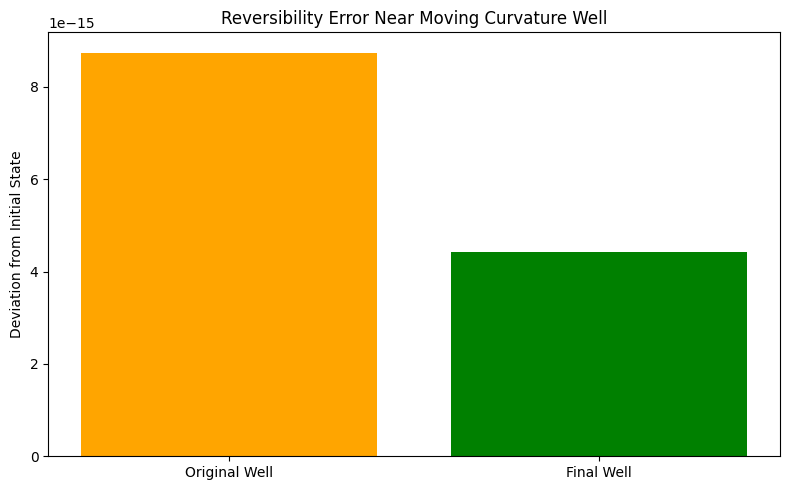

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 100
T = 50
x = np.linspace(0, 1, N)
v0 = np.sin(2 * np.pi * x)

# Moving curvature well: shifts from pos_A to pos_B
def moving_well(epoch, total_epochs, pos_A, pos_B, strength, width):
    center = pos_A + (pos_B - pos_A) * (epoch / total_epochs)
    return strength * np.exp(-((x - center)**2) / width)

# Full curvature field across epochs
def generate_curvature_field(epochs, pos_A, pos_B, strength, width):
    return [moving_well(e, epochs - 1, pos_A, pos_B, strength, width) for e in range(epochs)]

# Evolution with moving curvature
def evolve_moving(v_init, curvature_fields, steps):
    v = v_init.copy()
    traj = [v.copy()]
    all_noises = []
    for C in curvature_fields:
        noises = []
        for _ in range(steps):
            noise = np.random.randn(N) * (1.0 / (1.0 + C))
            v += noise
            traj.append(v.copy())
            noises.append(noise)
        all_noises.extend(noises)
    return np.array(traj), all_noises

# Reverse evolution
def evolve_reverse(v_final, curvature_fields, noises):
    v = v_final.copy()
    traj = [v.copy()]
    reversed_fields = curvature_fields[::-1]
    idx = 0
    for C in reversed_fields:
        for _ in range(T):
            noise = noises[-(idx + 1)]
            v -= noise
            traj.append(v.copy())
            idx += 1
    return np.array(traj)

# Local deviation metric
def local_deviation(v_recovered, v_original, region):
    start, end = region
    return np.linalg.norm(v_recovered[start:end] - v_original[start:end])

# Setup: well moves from 0.3 to 0.7
epochs = 3
pos_A = 0.3
pos_B = 0.7
strength = 5.0
width = 0.01
curvature_fields = generate_curvature_field(epochs, pos_A, pos_B, strength, width)

# Define regions: original and final well positions
region_A = (int((pos_A - 0.05) * N), int((pos_A + 0.05) * N))
region_B = (int((pos_B - 0.05) * N), int((pos_B + 0.05) * N))

# Run forward and reverse
traj_forward, noises = evolve_moving(v0, curvature_fields, T)
traj_reverse = evolve_reverse(traj_forward[-1], curvature_fields, noises)

# Compute deviations
dev_A = local_deviation(traj_reverse[-1], v0, region_A)
dev_B = local_deviation(traj_reverse[-1], v0, region_B)

# Plot results
plt.figure(figsize=(8, 5))
plt.bar(["Original Well", "Final Well"], [dev_A, dev_B], color=["orange", "green"])
plt.title("Reversibility Error Near Moving Curvature Well")
plt.ylabel("Deviation from Initial State")
plt.tight_layout()
plt.show()
